In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import save_video_from_images
import cv2

In [70]:
dataset_location = '' # put the root or relative path to your dataset here

scene_df1 = pd.read_hdf(dataset_location + 'scene.hdf5')
scene_df2 = pd.read_hdf(dataset_location + 'scene2.hdf5')
scene_df3 = pd.read_hdf(dataset_location + 'scene3.hdf5')
car_scene_df1 = pd.read_hdf(dataset_location + 'car_scene.hdf5')
car_scene_df2 = pd.read_hdf(dataset_location + 'car_scene2.hdf5')
car_scene_df3 = pd.read_hdf(dataset_location + 'car_scene3.hdf5')

KeyboardInterrupt: 

In [ ]:
def slice_array(arr, num=10, stride=8):
    t, x, y = arr.shape
    
    slices = []
    
    for i in range(0, x - x // num + 1, stride):
        for j in range(0, y - y // num + 1, stride):
            slice_x_start = i
            slice_x_end = i + x // num
            slice_y_start = j
            slice_y_end = j + y // num
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append((slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end)))
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    t, x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros((x, y))
    weight = np.zeros((x, y))
    
    for slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end) in slices:
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += slice_ij
        weight[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += 1
    
    # Avoid division by zero
    weight[weight == 0] = 1
    return rebuilt_array / weight

def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

def pick_regular_slices(arr, num):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices

def pseud_calibration(arr, num_slices, reg= 50, stride = 4):
    slices = slice_array(arr, num_slices,stride)
    t, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s[0]) for s in slices]
    original_means = [np.mean(s[0]) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s, reg) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    
    reconstructed = rebuild_array(list(zip(meaned, [(s[1][0], s[1][1], s[1][2], s[1][3]) for s in slices])), (t, x, y), num_slices)
    
    # Apply Gaussian blur to the reconstructed image to reduce block edges
    # smoothed_image = cv2.GaussianBlur(reconstructed, (5, 5), 0)
    
    return reconstructed

In [ ]:
def adjust_contrast(image, alpha, beta):
    """
    Adjust the contrast of a grayscale image.

    Parameters:
    image (np.ndarray): Input grayscale image as a NumPy array.
    alpha (float): Contrast control (1.0-3.0).
    beta (int): Brightness control (0-100).

    Returns:
    np.ndarray: Image with adjusted contrast.
    """
    # Apply the contrast adjustment
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    return adjusted_image


In [ ]:
def normalize(arr, min_val=0.0, max_val=1.0):
    """
    Normalizes the values of a NumPy array to a specified range.

    Args:
        arr (numpy.ndarray): Input array to be normalized.
        min_val (float): Minimum value of the normalized range (default: 0.0).
        max_val (float): Maximum value of the normalized range (default: 1.0).

    Returns:
        numpy.ndarray: Normalized array with values in the specified range.
    """
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    normalized_arr = (arr - arr_min) / (arr_max - arr_min)
    normalized_arr = normalized_arr * (max_val - min_val) + min_val
    return normalized_arr

In [ ]:
def psnr(original, compressed):
    mse = np.mean((normalize(original) - normalize(compressed)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

In [100]:
scene = np.stack(scene_df1["image"].values)
all_psnr = []
all_images = []
for i in range(2,30,2):
    print(f"trial {i} ongoing just wait")
    filter = pseud_calibration(scene, 32, 50,i)
    psnr_val = psnr(scene[-50],scene[-50]-filter)
    all_images.append(scene[-50]-filter)
    all_psnr.append(psnr_val)


trial 2 ongoing just wait
(400, 15, 20)
trial 4 ongoing just wait
(400, 15, 20)
trial 6 ongoing just wait
(400, 15, 20)
trial 8 ongoing just wait
(400, 15, 20)
trial 10 ongoing just wait
(400, 15, 20)
trial 12 ongoing just wait
(400, 15, 20)
trial 14 ongoing just wait
(400, 15, 20)
trial 16 ongoing just wait
(400, 15, 20)
trial 18 ongoing just wait
(400, 15, 20)
trial 20 ongoing just wait
(400, 15, 20)
trial 22 ongoing just wait
(400, 15, 20)
trial 24 ongoing just wait
(400, 15, 20)
trial 26 ongoing just wait
(400, 15, 20)
trial 28 ongoing just wait
(400, 15, 20)


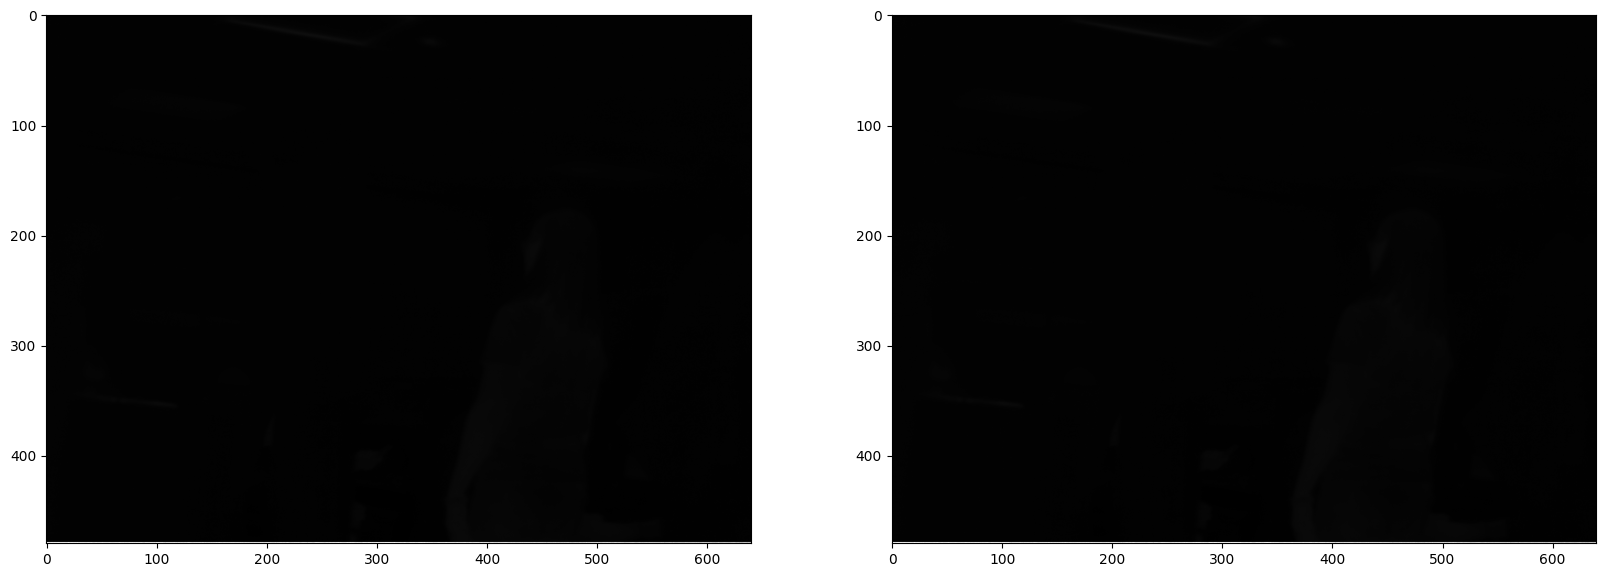

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,40))

ax1.imshow(all_images[0], cmap='gray')
ax2.imshow(all_images[1], cmap='gray')

plt.show()

In [102]:
print(all_psnr[0], all_psnr[1])

11.025181156113904 11.029907720775237


In [ ]:
filterd_image = normalize(filtered_scene[-50])

image = normalize(scene[-50])
print(np.std(image))
print(np.std(filterd_image))

0.026331365
0.04032516958789495


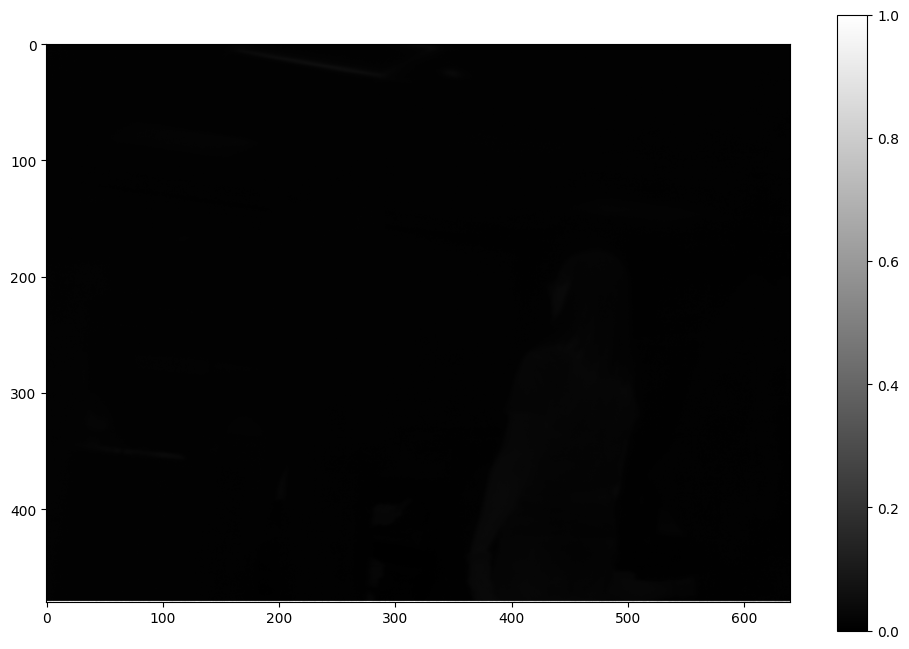

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(filterd_image, cmap='gray')

plt.colorbar()
plt.show()

In [ ]:
import cv2
import numpy as np

def adjust_luminosity_contrast(image: np.ndarray, alpha: float, beta: int) -> np.ndarray:
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def count_features(image: np.ndarray) -> int:
    orb = cv2.ORB_create()
    if image is None or image.size == 0 or len(image.shape) != 2:
        return 0
    keypoints = orb.detect(image, None)
    return len(keypoints)

def slice_with_most_features(array):
    orb = cv2.ORB_create()
    max_features = 0
    best_slice = None
    for t in range(array.shape[0]):
        slice_t = array[t]
        slice_t = slice_t.astype(np.uint8)
        keypoints = orb.detect(slice_t, None)
        if len(keypoints) > max_features:
            max_features = len(keypoints)
            best_slice = t
    return array[t]

def auto_adjust_luminosity_contrast(image: np.ndarray) -> np.ndarray:
    best_feature_count = -1
    best_image = None
    best_alpha = 0.01
    best_beta = 0
    if len(image.shape)==3:
        image = slice_with_most_features(image)
    print(image.shape)
    alpha_range = np.arange(0.01, 3.0, 0.005)
    beta_range = np.arange(0, 100, 5)

    for alpha in alpha_range:
        for beta in beta_range:
            adjusted_image = adjust_luminosity_contrast(image, alpha, beta)
            if adjusted_image is None or adjusted_image.size == 0 or np.isnan(adjusted_image).any():
                continue
            current_feature_count = count_features(adjusted_image)
            if current_feature_count > best_feature_count:
                best_feature_count = current_feature_count
                best_image = adjusted_image
                best_alpha = alpha
                best_beta = beta

    if best_image is None:
        raise ValueError("No valid image was found. Please check the input image and parameters.")
    
    print(f"Best alpha: {best_alpha}, Best beta: {best_beta}")
    return best_image, best_alpha, best_beta


In [ ]:
print(alpha, beta)

2.9849999999999994 0


In [ ]:
best, alpha, beta = auto_adjust_luminosity_contrast(scene-filter)
print(best)

(480, 640)
Best alpha: 1.5499999999999998, Best beta: 40
[[ 33  28  38 ...  25  14  22]
 [ 33  36  39 ...  24  25  19]
 [ 32  32  29 ...  18  16  23]
 ...
 [ 20  22  23 ...   5  15   5]
 [ 18  21  27 ...  12   1   5]
 [255 255 255 ... 255 255 255]]


0.11380413858251634


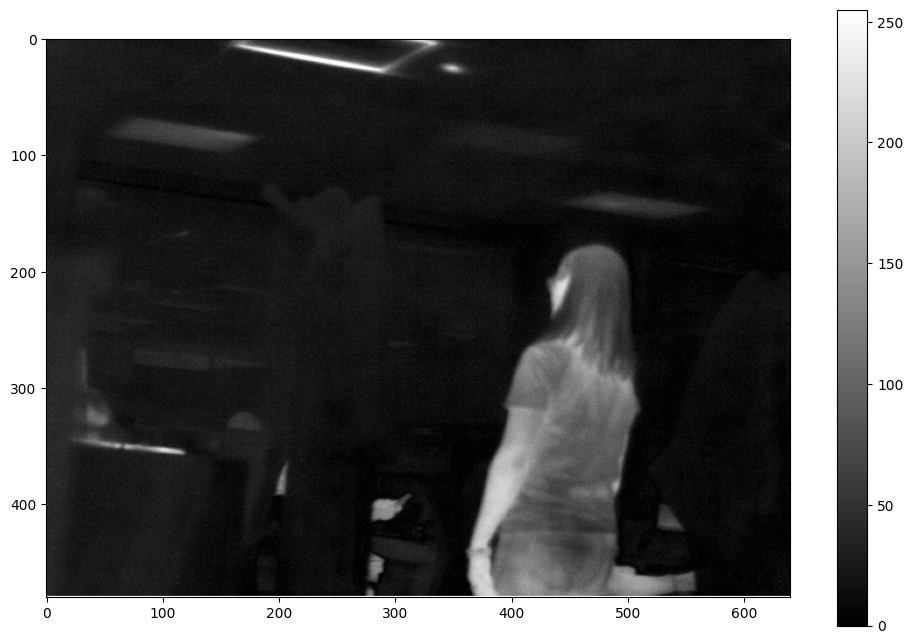

In [ ]:
frame = adjust_contrast((scene - filter)[350],1.55,40)
print(np.mean(normalize(frame)))
plt.figure(figsize=(12, 8))
plt.imshow(frame, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
all_vids = [scene_df1, scene_df2, scene_df3, car_scene_df1, car_scene_df2, car_scene_df3]
car_filter = pseud_calibration(np.stack(car_scene_df2["image"].values), 32)
scene_filter = pseud_calibration(np.stack(scene_df1["image"].values), 32)

for i, scene in enumerate(all_vids):
    location = "pseudo_calibration_blend/"
    name = f"scene{i+1}.avi" if i < 3 else f"car_scene{i-2}.avi"
    filter = scene_filter if i < 3 else car_filter

    scene = np.stack(scene["image"].values)
    filtered_scene = scene - filter

    

    if i <3:
        filtered_scene = adjust_contrast(filtered_scene, 1.1,100)
    else :
        filtered_scene = adjust_contrast(filtered_scene,0.03,0)
    save_video_from_images(filtered_scene, location + name)

(1001, 15, 20)
(400, 15, 20)


: 